<a href="https://colab.research.google.com/github/ydjoel/new/blob/main/final_draft_digit_recognizer_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# load data

In [ ]:
def load_mnist(filename):
    MNIST_data = h5py.File(filename, 'r')
    x_train = np.float32(MNIST_data['x_train'][:])
    y_train = np.int32(np.array(MNIST_data['y_train'][:,0]))
    x_test = np.float32(MNIST_data['x_test'][:])
    y_test = np.int32(np.array(MNIST_data['y_test'][:,0]))
    MNIST_data.close()
    print(f'train data elements = {x_train.shape[0]} num of features = {x_train.shape[1]}' )
    print(f'test  data elements = {x_test.shape[0]}  num of features = {x_test.shape[1]}' )
    return x_train,y_train,x_test,y_test

# initialize parameters

In [ ]:
def initialize(num_inputs,num_classes):
    
    w = np.random.randn(num_classes, num_inputs) / np.sqrt(num_classes*num_inputs) 
    b = np.random.randn(num_classes, 1) / np.sqrt(num_classes) 
    
    param = {
        'w' : w, # (10*784)
        'b' : b  # (10*1)
    }
    return param

# softmax function

In [ ]:
def softmax(z):

    exp_list = np.exp(z)
    result = 1/sum(exp_list) * exp_list
    result = result.reshape((len(z),1))
    assert (result.shape == (len(z),1))
    return result

# negative log loss

In [ ]:
def neg_log_loss(pred, label):
    loss = -np.log(pred[int(label)])
    return loss

# mini batch gradient

In [ ]:
def mini_batch_gradient(param, x_batch, y_batch):

    batch_size = x_batch.shape[0]
    w_grad_list = []
    b_grad_list = []
    batch_loss = 0
    for i in range(batch_size):
        x,y = x_batch[i],y_batch[i]
        x = x.reshape((784,1)) # x: (784,1)
        E = np.zeros((10,1)) #(10*1)
        E[y][0] = 1 
        pred = softmax(np.matmul(param['w'], x)+param['b']) #(10*1)

        loss = neg_log_loss(pred, y)
        batch_loss += loss

        w_grad = E - pred
        w_grad = - np.matmul(w_grad, x.reshape((1,784)))
        w_grad_list.append(w_grad)

        b_grad = -(E - pred)
        b_grad_list.append(b_grad)
      

    dw = sum(w_grad_list)/batch_size
    db = sum(b_grad_list)/batch_size
    #print("wgrad",w_grad_list[0])
    #print("bgrad",b_grad_list[0])
    return dw, db, batch_loss

# evaluation

In [ ]:
def eval(param, x_data, y_data):

    # w: (10*784), x: (10000*784), y:(10000,)
    loss_list = []
    w = param['w'].transpose()
    dist = np.array([np.squeeze(softmax(np.matmul(x_data[i], w))) for i in range(len(y_data))])

    result = np.argmax(dist,axis=1)
    accuracy = sum(result == y_data)/float(len(y_data))

    loss_list = [neg_log_loss(dist[i],y_data[i]) for i in range(len(y_data))]
    loss = sum(loss_list)
    return loss, accuracy,result

# training

In [ ]:
def train(param, hyp , x_train, y_train, x_test, y_test):

    num_epoches = hyp['num_epoches']
    batch_size = hyp['batch_size']
    learning_rate = hyp['learning_rate']
    test_loss_list, test_accu_list = [],[]
    train_loss_list,train_accu_list = [],[]
    train_results,test_results = [],[]

    for epoch in range(num_epoches):
        
        # select the random sequence of training set
        rand_indices = np.random.choice(x_train.shape[0],x_train.shape[0],replace=False)
        num_batch = int(x_train.shape[0]/batch_size)
        batch_loss100 = 0
        
        if bool(hyp['learning_decay']) == True:
            try:
                if test_accu_list[-1] - test_accu_list[-2] < 0.001:
                    learning_rate *= hyp['decay_factor']
            except:
                pass
            
            message = 'learning rate: %.8f' % learning_rate
            print(message)

        # for each batch of train data
        for batch in range(num_batch):
            index = rand_indices[batch_size*batch:batch_size*(batch+1)]
            x_batch = x_train[index]
            y_batch = y_train[index]

            # calculate the gradient w.r.t w and b
            dw, db, batch_loss = mini_batch_gradient(param, x_batch, y_batch)
            batch_loss100 += batch_loss
            # update the parameters with the learning rate
            
            param['w'] -= learning_rate * dw
            param['b'] -= learning_rate * db
            if batch % 100 == 0:
                message = 'Epoch %d, Batch %d, Loss %.2f' % (epoch+1, batch, batch_loss)
                #print(message)

                batch_loss100 = 0
        train_loss, train_accu,train_results = eval(param,x_train,y_train)
        test_loss, test_accu,test_results = eval(param,x_test,y_test)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_accu_list.append(train_accu)
        test_accu_list.append(test_accu)

        message = 'Epoch %d, Train Loss %.2f, Train Accu %.4f, Test Loss %.2f, Test Accu %.4f' % (epoch+1, train_loss, train_accu, test_loss, test_accu)
        print(message)
    return  train_loss_list,test_loss_list,train_accu_list,test_accu_list,train_results,test_results

# plotting

In [ ]:
def plot(loss_list_train,loss_list_test, accu_list_train,accu_list_test):

    plt.plot(loss_list_train)
    plt.ylabel('Loss Function - test')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Loss Function ~ Epoch')
    plt.show()

    '''plt.plot(loss_list_test)
    plt.ylabel('Loss Function - train')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Loss Function ~ Epoch')
    plt.show()'''

    '''plt.plot(accu_list_train)
    plt.ylabel('Train Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Train Accuracy ~ Epoch')
    plt.show()'''

    plt.plot(accu_list_test)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Epoch')
    plt.xticks(rotation=60)
    plt.title('Test Accuracy ~ Epoch')
    plt.show()

#displaying data

In [ ]:


x_train,y_train,x_test,y_test = load_mnist('MNISTdata.hdf5')

np.random.seed(1024)

num_inputs = x_train.shape[1]
num_classes = len(set(y_train))
param = initialize(num_inputs,num_classes)

hyperpara = {
    "num_epoches" : 20,
    "batch_size" : 100,
    "learning_rate" : 0.0025,
    "learning_decay" : 0,
    "decay_factor" : 0.75,
}


train data elements = 60000 num of features = 784
test  data elements = 10000  num of features = 784


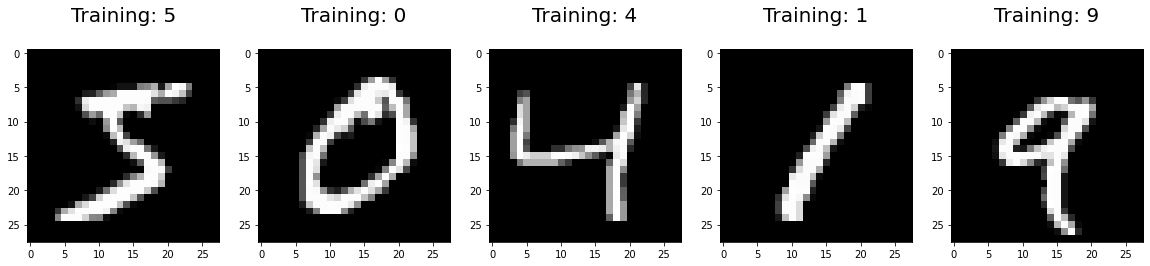

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))

for index, (image, label) in enumerate(zip(x_train[0:5], y_train[0:5])):
 plt.subplot(1, 5, index + 1)
 plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
 plt.title('Training: %i\n' % label, fontsize = 20)

In [ ]:
for i in range(56,76):
  print(y_train[i])

0
9
4
1
4
4
6
0
4
5
6
1
0
0
1
7
1
6
3
0


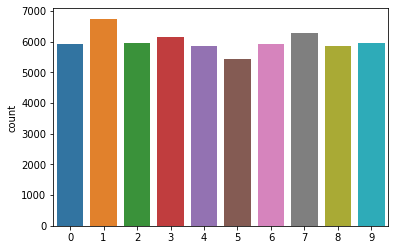

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

sns.countplot(x=y_train)
plt.show()# looks kinda okay

In [ ]:
loss_list_train,loss_list_test, accu_list_train,accu_list_test,_ ,test_pred = train(param,hyperpara,x_train,y_train,x_test,y_test)

Epoch 1, Train Loss 82086.40, Train Accu 0.7452, Test Loss 13536.04, Test Accu 0.7529
Epoch 2, Train Loss 61207.02, Train Accu 0.8098, Test Loss 9999.92, Test Accu 0.8166
Epoch 3, Train Loss 51202.08, Train Accu 0.8299, Test Loss 8311.06, Test Accu 0.8378
Epoch 4, Train Loss 45317.72, Train Accu 0.8426, Test Loss 7320.20, Test Accu 0.8499
Epoch 5, Train Loss 41463.02, Train Accu 0.8506, Test Loss 6676.35, Test Accu 0.8569
Epoch 6, Train Loss 38703.43, Train Accu 0.8559, Test Loss 6215.57, Test Accu 0.8642
Epoch 7, Train Loss 36658.19, Train Accu 0.8605, Test Loss 5876.60, Test Accu 0.8689
Epoch 8, Train Loss 35033.31, Train Accu 0.8633, Test Loss 5605.22, Test Accu 0.8725
Epoch 9, Train Loss 33708.93, Train Accu 0.8666, Test Loss 5387.91, Test Accu 0.8740
Epoch 10, Train Loss 32607.84, Train Accu 0.8694, Test Loss 5206.17, Test Accu 0.8770
Epoch 11, Train Loss 31654.25, Train Accu 0.8721, Test Loss 5049.38, Test Accu 0.8801
Epoch 12, Train Loss 30859.42, Train Accu 0.8737, Test Loss 49

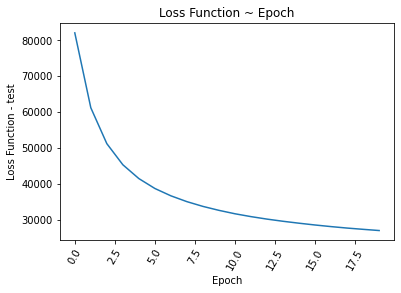

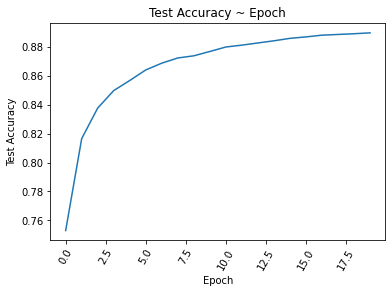

In [ ]:
plot(loss_list_train,loss_list_test, accu_list_train,accu_list_test)


In [ ]:


cm = metrics.confusion_matrix(y_test, test_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(accu_list_test[-1])
plt.title(all_sample_title, size = 15);

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       980
           1       0.96      0.95      0.96      1135
           2       0.88      0.87      0.87      1032
           3       0.84      0.89      0.87      1010
           4       0.89      0.91      0.90       982
           5       0.90      0.76      0.82       892
           6       0.89      0.94      0.91       958
           7       0.90      0.89      0.90      1028
           8       0.84      0.84      0.84       974
           9       0.87      0.85      0.86      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

